# Lendingkart

In [1]:
# Load necessary libraries
import sys
import warnings
warnings.filterwarnings('ignore')
import datetime
import gensim
import pandas as pd
import tqdm.notebook as tqdm
from tqdm.auto import tqdm
tqdm.pandas()

sys.path.append('/Users/pushkar/Documents/projects/fin_comp/comp/docs')

import utils.helper
from utils.helper import Processor
import importlib
importlib.reload(utils.helper)

import plotly.io as pio
svg_renderer = pio.renderers["svg"]
svg_renderer.width = 900
svg_renderer.height = 500
pio.renderers.default = "svg"
import plotly.express as px

In [2]:
# Load data
df = pd.read_csv('./../../data/fintech/lendingkart/lendingkart.csv')

In [3]:
# Company username
company_username = 'Lendingkart'

In [4]:
# Correct the format of variables
df['inReplyToTweetId'] = df['inReplyToTweetId'].apply(lambda x: '%.0f' % x).values.tolist()
df['conversation_id'] = df['conversation_id'].astype(str)

In [5]:
# Declare the query words
query_words = ['dm', 'customer experience', 'inconvenience', 'concern team', 'resolve', 
                'solve', 'no noc', 'await response', 'unpleasant experience']

In [6]:
# Declare the processor object
processor = Processor('./../../data/config.json')

In [7]:
# Check whether an observation is query for the company or not
df['is_query'] = 0

for word in tqdm(query_words):
    df['is_query'] = df['is_query'] + df['tweet'].apply(processor.word_distribution, find=word).astype(int)

  0%|          | 0/9 [00:00<?, ?it/s]

In [8]:
# Select observations of queries
qdf = df[(df['is_query']>0) & (df['username'] == company_username)]

In [9]:
qdf.shape

(1124, 28)

In [10]:
# Get all the conversation ids
conversation_ids = qdf['conversation_id'].unique()
print(f"Total number of unique conversations: {len(conversation_ids)}")

Total number of unique conversations: 736


In [11]:
df['date'] = pd.to_datetime(df['date'])

## Response time

Response time is the time the company takes to respond to the first query.

In [12]:
result = pd.DataFrame()
result['conversation_id'] = conversation_ids
result['response_time'] = 0

In [13]:
for index, conversation_id in enumerate(conversation_ids):
    tmp = df[df['conversation_id'] == conversation_id]
    tmp.sort_values('date', ascending=True, inplace=True)
    comp_tmp = tmp[tmp['username'] == company_username]
    response_time = (comp_tmp.iloc[0]['date'] - tmp.iloc[0]['date']) / datetime.timedelta(hours=1)
    result.at[index, 'response_time'] = response_time

In [14]:
result

,conversation_id,response_time
0,1343785976942882818,0.888056
1,1344177960446640130,0.610278
2,1313373475407491073,2.497500
3,1343868209510850564,3.420278
4,1343518600808677381,0.000000
...,...,...
731,1097425529492393984,0.000000
732,1099926708210167808,7.112778
733,1096309397372817408,0.346111
734,1096031343539118080,0.000000


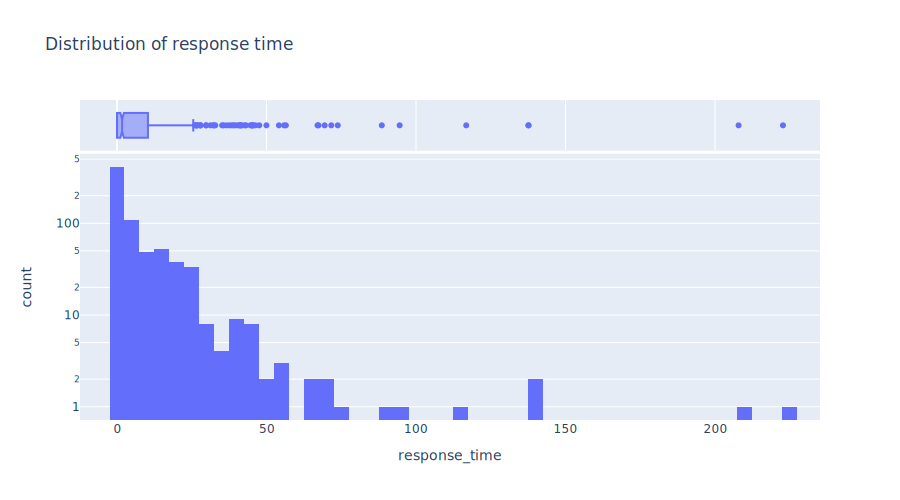

In [15]:
fig = px.histogram(result[result['response_time']<1000], x='response_time', log_y=True, marginal='box', title='Distribution of response time')
fig.show()

## Resolution time

Assuming that if the last query in the conversation is from the company then the issue is resolved.  
Resolution time is the time difference between the last date of last tweet in the conversation and the date of first query.

In [16]:
result['resolution_time'] = 0

In [17]:
for index, conversation_id in enumerate(conversation_ids):
    tmp = df[df['conversation_id'] == conversation_id]
    tmp.sort_values('date', ascending=True, inplace=True)
    comp_tmp = tmp[tmp['username'] == company_username]
    if tmp.iloc[-1]['username'] == company_username:
        resolution_time = (tmp.iloc[-1]['date'] - tmp.iloc[0]['date']) / datetime.timedelta(hours=1)
        result.at[index, 'resolution_time'] = resolution_time

In [18]:
print(f"Number of queries resolved: {len(result['resolution_time'].to_numpy().nonzero()[0])}")
print(f"Number of queries unresolved: {result.shape[0] - len(result['resolution_time'].to_numpy().nonzero()[0])}")

Number of queries resolved: 547
Number of queries unresolved: 189


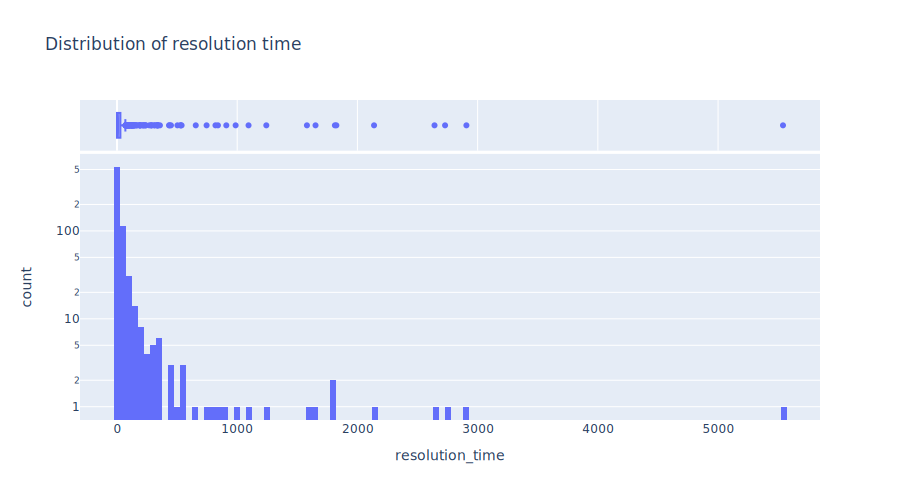

In [19]:
fig = px.histogram(result, x='resolution_time', log_y=True, marginal='box', title='Distribution of resolution time')
fig.show()

In [20]:
result.describe()

,response_time,resolution_time
count,736.000000,736.000000
mean,15.893941,71.104340
std,204.717685,324.559220
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.708194,4.345417
75%,10.396875,28.168056
max,5540.252222,5540.254722


## Query Tweets Topics

In [21]:
queries = df[df['conversation_id'].isin(conversation_ids)]
queries.sort_values('date', ascending=True, inplace=True)
queries = queries[queries['inReplyToTweetId'] == 'nan']

In [22]:
queries.shape

(648, 28)

In [23]:
processor = Processor('./../../data/config.json')

In [24]:
queries = processor.preprocess_individual(queries)

In [26]:
id2word = gensim.corpora.Dictionary(queries['bigram'].values.tolist())

In [27]:
corpus = [id2word.doc2bow(text) for text in queries['bigram'].values.tolist()]

In [62]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                        id2word=id2word,
                                        num_topics=4,
                                        random_state=100,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True,
                                        alpha=0.9,
                                        eta=0.3)

In [63]:
coherence_model = gensim.models.CoherenceModel(model=lda_model, 
                                                    texts=queries['bigram'].values.tolist(), 
                                                    dictionary=id2word, 
                                                    coherence='u_mass')
coherence_model_score = coherence_model.get_coherence()
print('Coherence Score: ', coherence_model_score)

Coherence Score:  -9.638592704311312


In [64]:
import pyLDAvis.gensim_models

import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.061347 -0.080842       1        1  29.320929
3     -0.050321  0.022522       2        1  25.461929
2     -0.004443  0.087909       3        1  23.029211
0      0.116110 -0.029588       4        1  22.187930, topic_info=                 Term        Freq       Total Category  logprob  loglift
617   contact_details   17.000000   17.000000  Default  30.0000  30.0000
831               ecs   25.000000   25.000000  Default  29.0000  29.0000
634  share_registered   15.000000   15.000000  Default  28.0000  28.0000
236         kindly_dm   15.000000   15.000000  Default  27.0000  27.0000
347               emi  109.000000  109.000000  Default  26.0000  26.0000
..                ...         ...         ...      ...      ...      ...
19               bank    8.982600   31.513495   Topic4  -5.3035   0.2505
250              time    8.913686   44.212526   Topic4  -5.3112  -0.0958
21               loan    8.879632  106.287331   Topic4  -5.3150  -0.9768
347               emi    8.751923  109.839435   Topic4  -5.3295  -1.0241
83           customer    7.435262   32.316151   Topic4  -5.4926   0.0363

[263 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
345       1  0.733273  account
345       2  0.101141  account
345       3  0.075856  account
345       4  0.101141  account
1090      3  0.799192  advance
...     ...       ...      ...
868       4  0.136515     want
2415      2  0.645466      war
1786      2  0.645252    worse
468       1  0.758790     year
405       1  0.798390    years

[455 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1])

In [65]:
queries_topic_sents_keywords = processor.dominant_topics(ldamodel=lda_model, 
                                                         corpus=corpus, 
                                                         texts=queries['bigram'].values.tolist(),
                                                         tweets=queries['tweet'].values.tolist())

In [67]:
queries_topic_sents_keywords['Topic_Keywords'].unique()

array(['ecs, contact_details, moratorium, share_registered, mail, kindly_dm, company, experience_officer, contact_solve, hai',
       'emi, moratorium, loan, response, business, service, rbi, customers, pay_emi, money',
       'moratorium, loan, mail, request, dont, bank, till, emi, want, know',
       'emi, loan, moratorium, account, time, lai, month, months, kindly, th'],
      dtype=object)

In [74]:
select = queries_topic_sents_keywords['Topic_Keywords'].unique()[1]
queries_topic_sents_keywords[queries_topic_sents_keywords['Topic_Keywords'] == select]['Text'].values

array(['Rakesh hesitated to get a bank loan because he had no property to place as security. All his problems were solved with a security-free loan from Lendingkart! Watch his full story here: https://t.co/ueOXD9MRJg  #AbHarVyapaariKoLoanMilega https://t.co/o9oJPRDy60',
       'Cash की चिंता करने के बजाय अपने business पर ध्यान दीजिये. Lendingkart आपके सपनों को साकार करने में मदद करेगा. \n#AbHarVyapaariKoLoanMilega https://t.co/7xzJY7zRQi',
       "@Lendingkart \nCompleted all steps for my loan disbursal as per lendingkart's email on 23.2.19. Amount not being disbursed. For what reason? \nLAI-101934324",
       '@Lendingkart not a good brand as I thought, intensionally delaying business loan therefore my project going late too..\n\nWorst experience',
       "@Lendingkart \nSee I already told you, nothing is gonna happen. And that's very true.\nThe most 3rd class customer service. https://t.co/gkNcxtGDXf",
       "About 3 out of 4 #MSMEs in India rely on personal savings or borrowings fr

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



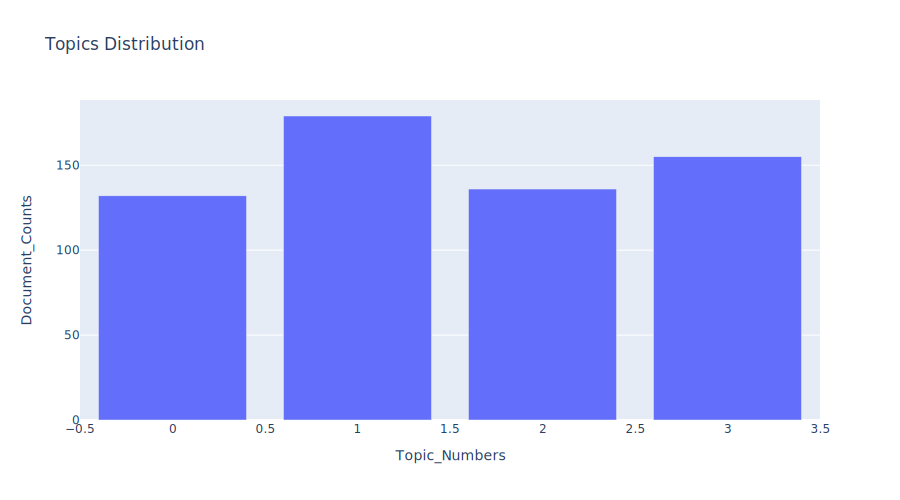

In [69]:
queries_dist, fig = processor.plot_topic_distribution(queries_topic_sents_keywords)
fig.show()